# Import Library
mengimpor library python yang digunakan untuk menganalisis dan membangun model machine learning

In [189]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

import kagglehub
import ast

# Loading Dataset

karena saya ingin merekomendasikan film saya perlu mengimpor dataset terlebih dahulu. Saya mengambil data dari kaggle.

pertama saya memasukkan setiap excelnya ke masing masing tempatnya, kemudian beberapa variabel saya lakukan head(), describe(), dan info() untuk mengetahui nilai dan informasi yang terdapat didalamnya. saya menampilkan grafik juga untuk melihat persebarannya.

In [190]:
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-movies-dataset


In [191]:
# Path to dataset files: /root/.cache/kagglehub/assets/rounakbanik/the-movies-dataset/current
movies_metadata_path = path + '/movies_metadata.csv'
credits_path = path + '/credits.csv'
keywords_path = path + '/keywords.csv'
ratings_path = path + '/ratings.csv'
links_path = path + '/links.csv'
links_small_path = path + '/links_small.csv'
ratings_small_path = path + '/ratings_small.csv'

In [192]:
# Load the datasets into pandas DataFrames
movies_metadata_df = pd.read_csv(movies_metadata_path, low_memory=False, nrows=10000)
credits_df = pd.read_csv(credits_path)
keywords_df = pd.read_csv(keywords_path)
ratings_df = pd.read_csv(ratings_path)
ratings_df = ratings_df[ratings_df['userId'] <= 1000]
links_df = pd.read_csv(links_path)
links_small_df = pd.read_csv(links_small_path)
ratings_small_df = pd.read_csv(ratings_small_path)

# Calculate and print the number of unique rows in each dataset
print(f"Jumlah data unik di movies_metadata.csv: {len(movies_metadata_df.drop_duplicates())}")
print(f"Jumlah data unik di credits.csv: {len(credits_df.drop_duplicates())}")
print(f"Jumlah data unik di keywords.csv: {len(keywords_df.drop_duplicates())}")
print(f"Jumlah data unik di ratings.csv: {len(ratings_df.drop_duplicates())}")
print(f"Jumlah data unik di links.csv: {len(links_df.drop_duplicates())}")
print(f"Jumlah data unik di links_small.csv: {len(links_small_df.drop_duplicates())}")
print(f"Jumlah data unik di ratings_small.csv: {len(ratings_small_df.drop_duplicates())}")


Jumlah data unik di movies_metadata.csv: 9997
Jumlah data unik di credits.csv: 45439
Jumlah data unik di keywords.csv: 45432
Jumlah data unik di ratings.csv: 98929
Jumlah data unik di links.csv: 45843
Jumlah data unik di links_small.csv: 9125
Jumlah data unik di ratings_small.csv: 100004


In [193]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [194]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  10000 non-null  bool   
 1   belongs_to_collection  1421 non-null   object 
 2   budget                 10000 non-null  int64  
 3   genres                 10000 non-null  object 
 4   homepage               662 non-null    object 
 5   id                     10000 non-null  int64  
 6   imdb_id                9999 non-null   object 
 7   original_language      10000 non-null  object 
 8   original_title         10000 non-null  object 
 9   overview               9971 non-null   object 
 10  popularity             10000 non-null  float64
 11  poster_path            9969 non-null   object 
 12  production_companies   10000 non-null  object 
 13  production_countries   10000 non-null  object 
 14  release_date           9995 non-null   object 
 15  rev

In [195]:
movies_metadata_df.isnull().sum()

,0
adult,0
belongs_to_collection,8579
budget,0
genres,0
homepage,9338
id,0
imdb_id,1
original_language,0
original_title,0
overview,29


In [196]:
movies_metadata_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04,9994.000000,10000.000000,10000.000000
mean,7.657425e+06,32252.159700,4.885920,2.105640e+07,103.596558,6.117420,179.850200
std,1.932593e+07,41321.251436,4.850015,7.157888e+07,26.022493,1.347176,555.452692
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,10318.500000,1.272692,0.000000e+00,91.000000,5.600000,11.000000
50%,0.000000e+00,20412.500000,3.473351,0.000000e+00,101.000000,6.300000,31.000000
75%,3.701384e+06,40921.500000,7.496737,6.659616e+06,113.000000,6.925000,109.000000
max,2.000000e+08,445590.000000,140.950236,1.845034e+09,720.000000,10.000000,9678.000000


In [197]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [198]:
credits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [199]:
credits_df.isnull().sum()

,0
cast,0
crew,0
id,0


In [200]:
credits_df.describe()

,id
count,45476.000000
mean,108345.997537
std,112443.796536
min,2.000000
25%,26443.250000
50%,60002.500000
75%,157302.000000
max,469172.000000


In [201]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [202]:
keywords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [203]:
keywords_df.isnull().sum()

,0
id,0
keywords,0


In [204]:
keywords_df.describe()

,id
count,46419.000000
mean,109769.951873
std,113045.780256
min,2.000000
25%,26810.500000
50%,61198.000000
75%,159908.500000
max,469172.000000


In [205]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [206]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98929 entries, 0 to 98928
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     98929 non-null  int64  
 1   movieId    98929 non-null  int64  
 2   rating     98929 non-null  float64
 3   timestamp  98929 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.8 MB


In [207]:
ratings_df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [208]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,98929.000000,98929.000000,98929.000000,9.892900e+04
mean,520.362422,15327.294464,3.528606,1.165144e+09
std,282.074272,30521.791447,1.022471,2.017499e+08
min,1.000000,1.000000,0.500000,8.285051e+08
25%,303.000000,1090.000000,3.000000,9.810532e+08
50%,521.000000,2596.000000,3.500000,1.146248e+09
75%,765.000000,6104.000000,4.000000,1.330855e+09
max,1000.000000,176271.000000,5.000000,1.501822e+09


In [209]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [210]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [211]:
links_df.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,219


In [212]:
links_df.describe()

,movieId,imdbId,tmdbId
count,45843.000000,4.584300e+04,45624.000000
mean,96578.775626,9.937080e+05,108661.382847
std,57216.863469,1.361924e+06,112665.970830
min,1.000000,1.000000e+00,2.000000
25%,49202.500000,8.333050e+04,26502.750000
50%,108799.000000,2.839910e+05,60178.000000
75%,145270.500000,1.538311e+06,157849.500000
max,176279.000000,7.158814e+06,469172.000000


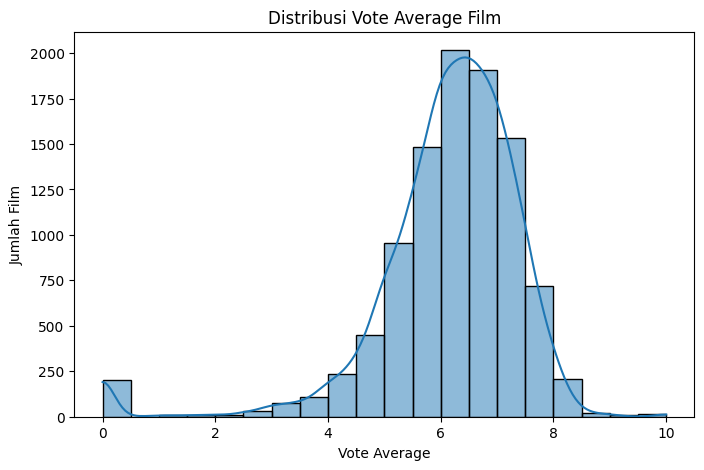

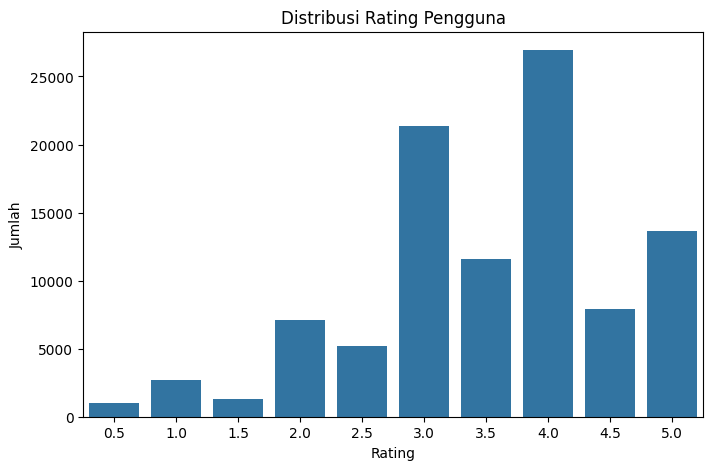

In [213]:
plt.figure(figsize=(8,5))
sns.histplot(movies_metadata_df['vote_average'].dropna(), bins=20, kde=True)
plt.title('Distribusi Vote Average Film')
plt.xlabel('Vote Average')
plt.ylabel('Jumlah Film')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

# Pembersihan dan Pra Pemrosesan Data

pada tahap ini saya melakukan pembersihan dataset untuk menjadikan dataset mudah diintepretasikan dan bisa dilatih. hal yang saya lakukan

1. saya melakukan penggabungan data sesuai dengan ID

2. mengecek nilai hilang dan duplikat, saya lakukan penghapusan untuk nilai yang duplikat

In [214]:
movies_metadata_df = movies_metadata_df[['id', 'title', 'overview', 'genres']].dropna(subset=['overview'])
movies_metadata_df['id'] = movies_metadata_df['id'].astype(str).str.split('.').str[0]

credits_df['id'] = credits_df['id'].astype(str)
keywords_df['id'] = keywords_df['id'].astype(str)

movies = movies_metadata_df.merge(credits_df, on='id').merge(keywords_df, on='id')

In [215]:
def get_director(crew):
    try:
        crew_list = ast.literal_eval(crew)
        if isinstance(crew_list, list):
            for person in crew_list:
                if isinstance(person, dict) and person.get('job') == 'Director':
                    return person.get('name', '')
    except (ValueError, SyntaxError):
        pass
    return ''

def get_list(obj):
    try:
        obj_list = ast.literal_eval(obj)
        if isinstance(obj_list, list):
             return [item.get('name', '') for item in obj_list if isinstance(item, dict)]
    except (ValueError, SyntaxError):
        pass
    return []

movies['cast'] = movies['cast'].apply(lambda x: get_list(x)[:3])
movies['crew'] = movies['crew'].apply(get_director)
movies['keywords'] = movies['keywords'].apply(get_list)
movies['genres'] = movies['genres'].apply(get_list)

movies['soup'] = movies['overview'] + ' ' + movies['crew'] + ' ' + \
                 movies['cast'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['keywords'].apply(lambda x: ' '.join(x))

In [216]:
movies.isnull().sum()

,0
id,0
title,0
overview,0
genres,0
cast,0
crew,0
keywords,0
soup,0


In [217]:
for col in ['cast', 'genres', 'keywords']:
    if col in movies.columns:
        movies[col] = movies[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

print(movies.duplicated().sum())

51


In [218]:
movies.drop_duplicates(inplace=True)

In [219]:
ratings = ratings_df.merge(links_df, on='movieId').dropna(subset=['tmdbId'])
ratings['tmdbId'] = ratings['tmdbId'].astype(int).astype(str)

ratings = ratings.groupby(['userId', 'tmdbId'])['rating'].mean().reset_index()

R_df = ratings.pivot(index='userId', columns='tmdbId', values='rating').fillna(0)
R = R_df.values
user_ratings_mean = R.mean(axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)
preds = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(preds, columns=R_df.columns)

movie_map = movies[['id', 'title']].drop_duplicates().set_index('id')



In [220]:
ratings.isnull().sum()

,0
userId,0
tmdbId,0
rating,0


In [221]:
ratings.duplicated().sum()

np.int64(0)

In [222]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies['soup'])

# Membangun model

tahap ini melakukan pembobotan dengan teknik TF-IDF.

saya menggunakan 2 model :`

- Content-Based Filtering
- Collaborative Filtering

collaborative akan menampilkan RMSE sedangkan CBF menampilkan precision, recall, dan f1-score.

In [223]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def content_recommend(title, cosine_sim=cosine_sim):
    if title not in indices:
        return ["Judul tidak ditemukan"]
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

In [224]:
print("\nTop 10 Rekomendasi Film Berdasarkan Konten untuk 'Toy Story':")
print(content_recommend('Toy Story'))

print("\nTop 10 Rekomendasi Film Berdasarkan Konten untuk 'The Dark Knight Rises':")
print(content_recommend('The Dark Knight Rises'))


Top 10 Rekomendasi Film Berdasarkan Konten untuk 'Toy Story':
['Toy Story 2', 'Small Soldiers', 'The Champ', 'Toys', 'Everything You Always Wanted to Know About Sex *But Were Afraid to Ask', 'Dolls', 'Take the Money and Run', 'The Transformers: The Movie', 'Stardust Memories', "Child's Play 3"]

Top 10 Rekomendasi Film Berdasarkan Konten untuk 'The Dark Knight Rises':
['Judul tidak ditemukan']


In [225]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_content_based(recommendations, actual_movies, k=10):

    top_k_recommendations = recommendations[:k]

    recommended_set = set(top_k_recommendations)
    actual_set = set(actual_movies)

    true_positives = len(recommended_set.intersection(actual_set))

    precision = true_positives / k if k > 0 else 0

    if not actual_set:
      recall = 1.0 if true_positives == 0 else 0.0
    else:
      recall = true_positives / len(actual_set)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

recommended_movies_for_toy_story = content_recommend('Toy Story')

toy_story_genres = movies[movies['title'] == 'Toy Story']['genres'].iloc[0]
if isinstance(toy_story_genres, tuple):
    toy_story_genres = list(toy_story_genres)

actual_relevant_movies = movies[movies['genres'].apply(lambda genres_list: any(genre in genres_list for genre in toy_story_genres))]

actual_relevant_movie_titles = actual_relevant_movies['title'].tolist()

precision_ts, recall_ts, f1_ts = evaluate_content_based(recommended_movies_for_toy_story, actual_relevant_movie_titles)

print(f"\nEvaluasi Rekomendasi Content-Based untuk 'Toy Story':")
print(f"  Precision: {precision_ts:.4f}")
print(f"  Recall: {recall_ts:.4f}")
print(f"  F1-score: {f1_ts:.4f}")


Evaluasi Rekomendasi Content-Based untuk 'Toy Story':
  Precision: 0.8000
  Recall: 0.0021
  F1-score: 0.0041


In [226]:
def collab_recommend(user_id, preds_df=preds_df, movies=movies, original_ratings=R_df):
    user_row = preds_df.iloc[user_id - 1]
    already_rated = original_ratings.iloc[user_id - 1]
    unrated = user_row[already_rated == 0].sort_values(ascending=False)
    top_movies = unrated.head(10).index
    return [movie_map.loc[mid]['title'] if mid in movie_map.index else 'Unknown' for mid in top_movies]

In [227]:
print("\nTop 10 Rekomendasi Film Berdasarkan Collaborative Filtering untuk Pengguna 1:")
print(collab_recommend(1))

print("\nTop 10 Rekomendasi Film Berdasarkan Collaborative Filtering untuk Pengguna 10:")
print(collab_recommend(10))



Top 10 Rekomendasi Film Berdasarkan Collaborative Filtering untuk Pengguna 1:
['Unknown', 'The Shawshank Redemption', 'The Lord of the Rings: The Return of the King', 'The Lord of the Rings: The Fellowship of the Ring', 'The Matrix', 'The Lord of the Rings: The Two Towers', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

Top 10 Rekomendasi Film Berdasarkan Collaborative Filtering untuk Pengguna 10:
['The Shawshank Redemption', 'Forrest Gump', 'Jurassic Park', 'Terminator 2: Judgment Day', 'Outbreak', 'GoldenEye', 'The Lion King', 'Braveheart', 'Crimson Tide', 'Speed']


RMSE Collaborative Filtering: 2.1458


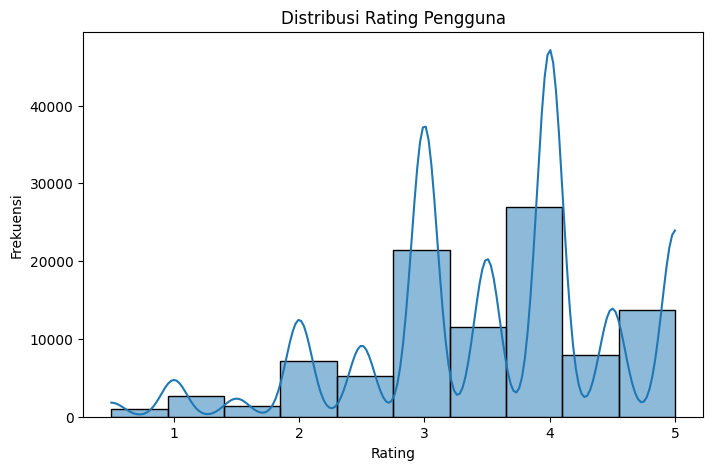

In [228]:
mask = np.random.rand(len(ratings)) < 0.8
train_ratings = ratings[mask]
test_ratings = ratings[~mask]

test_df = test_ratings.copy()
user_id_map = {uid: idx for idx, uid in enumerate(R_df.index)}
test_df['pred'] = test_df.apply(
    lambda row: preds_df.loc[user_id_map.get(row['userId'], 0)].get(str(int(row['tmdbId'])), np.nan), axis=1)

rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['pred']))
print(f"RMSE Collaborative Filtering: {rmse:.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

In [229]:
from IPython.display import display
import ipywidgets as widgets

def show_content_based():
    input_film = widgets.Text(value='The Avengers', placeholder='Masukkan judul film', description='Film:')
    button = widgets.Button(description="Rekomendasikan")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            hasil = content_recommend(input_film.value)
            print("Rekomendasi berdasarkan film:", input_film.value)
            for i, film in enumerate(hasil, 1):
                print(f"{i}. {film}")

    button.on_click(on_button_clicked)
    display(input_film, button, output)

def show_collab_based():
    input_user = widgets.BoundedIntText(value=1, min=1, max=610, step=1, description='User ID:')
    button = widgets.Button(description="Rekomendasikan")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            hasil = collab_recommend(input_user.value)
            print(f"Rekomendasi untuk user {input_user.value}:")
            for i, film in enumerate(hasil, 1):
                print(f"{i}. {film}")

    button.on_click(on_button_clicked)
    display(input_user, button, output)

show_content_based()
show_collab_based()

Text(value='The Avengers', description='Film:', placeholder='Masukkan judul film')

Button(description='Rekomendasikan', style=ButtonStyle())

Output()

BoundedIntText(value=1, description='User ID:', max=610, min=1)

Button(description='Rekomendasikan', style=ButtonStyle())

Output()